### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
# Constants:
H_0 = 70 * 1000 / (3.086e22)  # Hubble constant in SI units: 70 km/s/Mpc converted to 1/s
c = 3e8  # Speed of light in m/s
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
q0 = -0.534  # Deceleration parameter (assumed from Planck fit)

Read the csv data into the python using the method below

In [39]:
file_path = "C:/Users/Ansh/Downloads/Skyserver_SQL6_17_2025 4_59_10 AM.csv" # Download the data as instructed in the pdf
df = pd.read_csv(file_path, skiprows=1, dtype={'objid': str})

In [40]:
df.head()

,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type
0,1237671939804627535,258.48871,64.111343,0.079721,0.009565,0.080896,0.000023,9.483374,19.85553,0.067158,17.81776,0.006378,16.88524,0.004627,3
1,1237671939804627535,258.48871,64.111343,0.079721,0.009565,0.080899,0.000029,9.483374,19.85553,0.067158,17.81776,0.006378,16.88524,0.004627,3
2,1237671939804627518,258.46676,64.119499,0.088762,0.016934,0.082876,0.000006,8.986029,18.92277,0.036291,17.83406,0.006814,17.36895,0.006322,3
3,1237671939804627483,258.43205,64.123685,0.077184,0.010523,0.080790,0.000025,8.146154,20.08116,0.082063,18.15476,0.007831,17.27835,0.005706,3
4,1237671939804627464,258.44994,64.025909,0.081894,0.013624,0.071802,0.000025,9.316140,20.05525,0.065651,18.35306,0.008030,17.51662,0.005923,3


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [18]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({'specz': 'mean','ra': 'first','dec': 'first','proj_sep': 'first',}).reset_index()
averaged_df.describe()['specz']

count    92.000000
mean      0.080838
std       0.008578
min       0.069976
25%       0.077224
50%       0.080961
75%       0.082797
max       0.150886
Name: specz, dtype: float64

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [19]:
mean_specz = averaged_df['specz'].mean()
std_specz = averaged_df['specz'].std()
lower_limit = mean_specz - 3 * std_specz
upper_limit = mean_specz + 3 * std_specz

# Filter the data
filtered_df = averaged_df[(averaged_df['specz'] >= lower_limit) & (averaged_df['specz'] <= upper_limit)]

print(f"Mean Redshift: {mean_specz:.4f}")
print(f"Std Dev Redshift: {std_specz:.4f}")
print(f"3-sigma Lower Limit: {lower_limit:.4f}")
print(f"3-sigma Upper Limit: {upper_limit:.4f}")

Mean Redshift: 0.0808
Std Dev Redshift: 0.0086
3-sigma Lower Limit: 0.0551
3-sigma Upper Limit: 0.1066


You can also use boxplot to visualize the overall values of redshift 

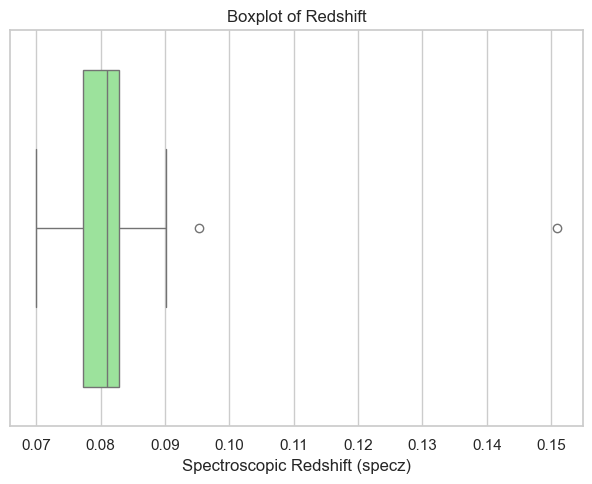

In [ ]:
# Plot the dsitribution of redshift as histogram and a boxplot 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
sns.boxplot(x=averaged_df['specz'], color='lightgreen')
plt.title("Boxplot of Redshift")
plt.xlabel("Spectroscopic Redshift (specz)")

plt.tight_layout()
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

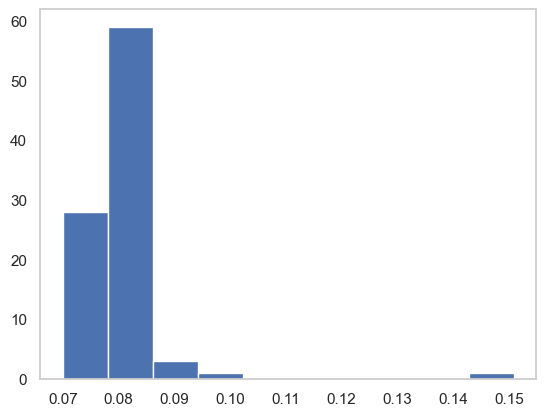

In [21]:
plt.hist(averaged_df['specz'],bins=10)
plt.grid()
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [ ]:
#filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.

print("\nRedshift Filtering")
mean_specz = averaged_df['specz'].mean()
std_specz = averaged_df['specz'].std()

if pd.isna(std_specz) or std_specz == 0:
    print("Warning: Standard deviation of redshift is NaN or zero. Cannot apply 3-sigma filter.")
    print("This might happen if all 'specz' values are identical after averaging or if there's insufficient data.")
    filtered_df = averaged_df.copy()
    lower_limit = mean_specz
    upper_limit = mean_specz
else:
    lower_limit = mean_specz - 3 * std_specz
    upper_limit = mean_specz + 3 * std_specz

    if lower_limit < 0:
        lower_limit = 0

    filtered_df = averaged_df[(averaged_df['specz'] >= lower_limit) & (averaged_df['specz'] <= upper_limit)].copy()

print(f"Original number of galaxies: {len(averaged_df)}")
print(f"Mean Redshift: {mean_specz:.4f}")
print(f"Standard Deviation of Redshift: {std_specz:.4f}")
print(f"3-sigma Lower Limit (Redshift): {lower_limit:.4f}")
print(f"3-sigma Upper Limit (Redshift): {upper_limit:.4f}")
print(f"Number of galaxies after 3-sigma filtering: {len(filtered_df)}")



Redshift Filtering
Original number of galaxies: 92
Mean Redshift: 0.0808
Standard Deviation of Redshift: 0.0086
3-sigma Lower Limit (Redshift): 0.0551
3-sigma Upper Limit (Redshift): 0.1066
Number of galaxies after 3-sigma filtering: 91


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [23]:
c_val = c
G_val = G 


In [ ]:
print("\nAdding Velocity Column")
# Calculate cluster redshift from the filtered data
cluster_redshift = filtered_df['specz'].mean()
print(f"Mean redshift of the identified cluster (from filtered data): {cluster_redshift:.4f}")

filtered_df['velocity'] = c_val * (
    ((1 + filtered_df['specz'])**2 - (1 + cluster_redshift)**2) /
    ((1 + filtered_df['specz'])**2 + (1 + cluster_redshift)**2)
)

print("'velocity' column successfully added to 'filtered_df' (values in m/s).")
print("Example velocities (first 5 in km/s):")
print((filtered_df['velocity'].head() / 1000).round(2))


Adding Velocity Column
Mean redshift of the identified cluster (from filtered data): 0.0801
'velocity' column successfully added to 'filtered_df' (values in m/s).
Example velocities (first 5 in km/s):
0     662.82
1     319.41
2    -139.88
3     214.89
4    1249.41
Name: velocity, dtype: float64


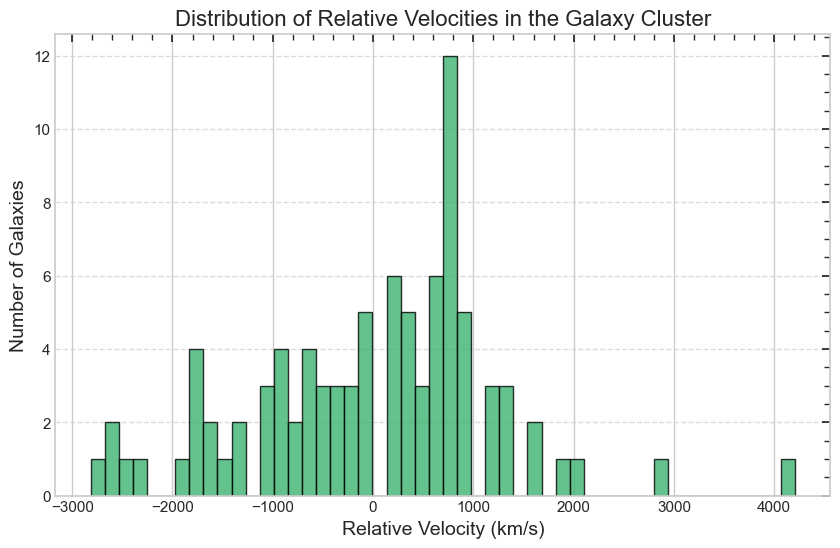

In [ ]:
#plot the velocity column created as hist
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['velocity'] / 1000, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.8)
plt.title("Distribution of Relative Velocities in the Galaxy Cluster", fontsize=16)
plt.xlabel("Relative Velocity (km/s)", fontsize=14)
plt.ylabel("Number of Galaxies", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.show()

In [ ]:
#calculate Velocity Dispersion
velocity_dispersion_ms = filtered_df['velocity'].std()

#convert velocity dispersion to km/s for standard astronomical units
velocity_dispersion_kms = velocity_dispersion_ms / 1000

print(f"The characteristic value of velocity dispersion of the cluster along the line of sight (sigma):")
print(f"  = {velocity_dispersion_ms:.2e} m/s")
print(f"  = {velocity_dispersion_kms:.2f} km/s")

#provide some context/sanity check for the calculated dispersion
if velocity_dispersion_kms > 0 and velocity_dispersion_kms < 2000:
    print("\nThis velocity dispersion value is typical for a galaxy cluster.")
elif velocity_dispersion_kms >= 2000:
    print("\nThis velocity dispersion is very high, suggesting a particularly massive or dynamically active cluster.")
else:
    print("\nThe calculated velocity dispersion is very low or zero. This might indicate an issue with")
    print("data, filtering, or that the selected galaxies do not form a distinct cluster.")


The characteristic value of velocity dispersion of the cluster along the line of sight (sigma):
  = 1.22e+06 m/s
  = 1219.34 km/s

This velocity dispersion value is typical for a galaxy cluster.


use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [29]:
mean_cluster_redshift = filtered_df['specz'].mean()
print(f"The mean redshift of the cluster is: {mean_cluster_redshift:.4f}")

The mean redshift of the cluster is: 0.0801


Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [30]:
print(filtered_df['velocity'].describe() / 1000)

count       0.091000
mean       -2.451027
std      1219.336490
min     -2816.179091
25%      -807.165187
50%       237.343287
75%       755.500236
max      4209.048637
Name: velocity, dtype: float64


In [37]:

print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {velocity_dispersion_ms / 1000 :.4} km/s.")

The value of the cluster redshift = 0.08007
The characteristic value of velocity dispersion of the cluster along the line of sight = 1.219e+03 km/s.


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



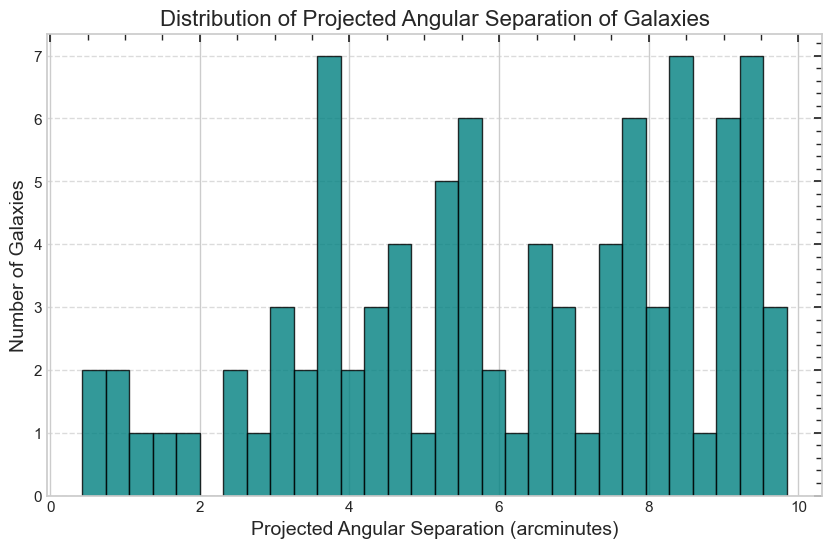

In [32]:
#Plot histogram for proj sep column
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['proj_sep'], bins=30, color='teal', edgecolor='black', alpha=0.8)
plt.title("Distribution of Projected Angular Separation of Galaxies", fontsize=16)
plt.xlabel("Projected Angular Separation (arcminutes)", fontsize=14)
plt.ylabel("Number of Galaxies", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [33]:
r= (c * cluster_redshift / H_0) * (1 - (cluster_redshift / 2) * (1 + q0))
ra= r / (1 + cluster_redshift)

max_proj_sep_arcmin = filtered_df['proj_sep'].max()
# Convert this angular size from arcminutes to radians
angular_size_radians = max_proj_sep_arcmin * (u.arcmin).to(u.rad)
# Calculate physical diameter in meters, then convert to Mpc
diameter_meters = ra * angular_size_radians
diameter = diameter_meters / (3.086e22) # diameter in Mpc (1 Mpc = 3.086e22 meters)

diameter

np.float64(0.892837376082904)

### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [38]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((velocity_dispersion_kms*1000)**2)*(diameter*0.5*10**6*3*10**16)/(G*2*10**30)

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 4.48e+14 solar mass
